# CNN Baseline Modeling

This notebook implements a CNN baseline for predicting joint output distributions of quantum circuits.
The CNN treats each quantum circuit as a sequence of gate-level features derived from its graph representation.

Key features:
- Converts graph-based quantum circuits into padded sequences of gate features
- Uses a 1D CNN architecture over the gate sequence
- Implements the same transfer learning and evaluation pipeline as the GNN
- Scales model complexity with qubit count similarly to the GNN baseline
- Uses identical stratified splitting and distributional evaluation metrics

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Imports
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.stats import entropy as scipy_entropy
from scipy.stats import wasserstein_distance

## Reproducibility

In [3]:
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

## Version Info

In [4]:
print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)

Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PyTorch version: 2.2.2+cu121


## Device Setup

In [5]:
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Data Conversion: Graph to ....

In [6]:
def convert_graph_to_sequence(graph_data, max_len=40):
    """
    Converts a graph-based quantum circuit into a fixed-length sequence of gate feature vectors.

    Each gate in the circuit is represented by a feature vector (from graph_data.x).
    """
    x = graph_data.x
    n_gates, feat_dim = x.shape
    pad_len = max(0, max_len - n_gates)
    if pad_len > 0:
        padding = torch.zeros((pad_len, feat_dim), dtype=x.dtype)
        x_padded = torch.cat([x, padding], dim=0)
    else:
        x_padded = x[:max_len]
    return x_padded, graph_data.u, graph_data.y

In [7]:
class SequenceCircuitDataset(torch.utils.data.Dataset):
    """
    A dataset that transforms a list of quantum circuit graphs into sequences suitable for 1D CNN input.

    Each circuit is represented as a padded sequence of gate-level feature vectors,
    along with global features and target probability distributions.
    """
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        g = self.data_list[idx]
        sequence, global_feat, target = convert_graph_to_sequence(g)
        return {
            'sequence': sequence,
            'global': global_feat,
            'target': target,
            'circuit_class': g.class_label,
            'noise_regime': getattr(g, 'noise_regime', 'unknown'),
            'n_qubits': g.n_qubits
        }

In [8]:
# Custom DataLoader collate function
def collate_sequence(batch):
    """
    Collates a batch of sequence-encoded circuit samples into batched tensors.
    """
    sequences = torch.stack([item['sequence'] for item in batch])
    global_feats = torch.stack([item['global'] for item in batch])
    targets = torch.stack([item['target'] for item in batch])

    return {
        'sequence': sequences,
        'global': global_feats,
        'target': targets
    }

## CNN Architecture

In [9]:
class SequenceCNN(nn.Module):
    """
    CNN model for predicting output distributions of quantum circuits.
    Applies a 1D convolution over gate-level sequences, combines with global features,
    and passes through a shallow MLP head.
    """
    def __init__(self, input_dim, global_dim, output_dim, hidden_2q=58, n_qubits=2):
        super().__init__()
        scale = (n_qubits - 1) * 1.3
        hidden = int(hidden_2q * scale)

        self.conv = nn.Conv1d(input_dim, hidden, kernel_size=5, padding=2)
        self.global_proj = nn.Linear(global_dim, hidden)
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden, 4 * hidden),
            nn.ReLU(),
            nn.Linear(4 * hidden, 2 * hidden),
            nn.ReLU(),
            nn.Linear(2 * hidden, output_dim)
        )

    def forward(self, sequence_data, global_features):
        x = sequence_data.permute(0, 2, 1)
        x = self.conv(x).mean(dim=2)
        u_proj = self.global_proj(global_features)
        return self.mlp(torch.cat([x, u_proj], dim=1))



def build_cnn_model(sample_data, hidden_2q=58):
    """
    Builds a SequenceCNN model for a single sample.
    """
    sequence_sample, global_sample, target_sample = convert_graph_to_sequence(sample_data)

    input_channels = sequence_sample.shape[1]
    global_dim = global_sample.shape[0]
    output_dim = target_sample.shape[0]
    n_qubits = sample_data.n_qubits

    model = SequenceCNN(
        input_dim=input_channels,
        global_dim=global_dim,
        output_dim=output_dim,
        n_qubits=n_qubits,
        hidden_2q=hidden_2q
    )

    print(f"CNN Model has {sum(p.numel() for p in model.parameters()):,} parameters.")
    return model

## Model Saving

In [10]:
def save_model(model, qubit_size, model_dir="../models/cnn_models"):
    """
    Save the trained SequenceCNN model to disk.
    """
    os.makedirs(model_dir, exist_ok=True)
    fpath = os.path.join(model_dir, f"{qubit_size}q_cnn.pt")
    torch.save(model.state_dict(), fpath)
    print(f"Saved CNN model to {fpath}")

## Transfer Learning Utilities: Weight Interpolation, Expansion, and Layer Freezing

In [11]:
def interpolate_weights(old_weight, new_shape):
    """Interpolates a tensor to a new shape by copying overlapping values and adding small noise."""
    new_weight = torch.zeros(new_shape)
    min_shape = [min(o, n) for o, n in zip(old_weight.shape, new_shape)]
    slices_old = tuple(slice(0, s) for s in min_shape)
    slices_new = tuple(slice(0, s) for s in min_shape)
    new_weight[slices_new] = old_weight[slices_old]
    if new_weight.shape != old_weight.shape:
        new_weight += torch.randn_like(new_weight) * 0.01
    return new_weight


def expand_and_load_weights(old_state, new_model):
    """
    Loads weights from a smaller CNN model into a larger one using shape-aware interpolation.
    """
    new_state = new_model.state_dict()
    updated_state = {}

    for k in new_state:
        if k in old_state:
            old_w = old_state[k]
            new_w = new_state[k]
            if old_w.shape == new_w.shape:
                updated_state[k] = old_w
            else:
                if old_w.ndim <= 2:
                    updated_state[k] = interpolate_weights(old_w, new_w.shape)
                else:
                    print(f"Skipping complex reshape for: {k} (shape {old_w.shape} → {new_w.shape})")
        else:
            print(f"Parameter not found in old model: {k}")

    new_state.update(updated_state)
    new_model.load_state_dict(new_state)
    return new_model


def freeze_layers(model, freeze_keys=None):
    """
    Freezes parameters in the CNN whose names contain any of the specified substrings.
    """
    for name, param in model.named_parameters():
        if freeze_keys is None or any(k in name for k in freeze_keys):
            param.requires_grad = False


def unfreeze_all_layers(model):
    """
    Unfreezes all layers in the CNN model.
    """
    for param in model.parameters():
        param.requires_grad = True


def load_and_expand_model(prev_qubit, sample_data, hidden_2q=104, model_dir="../models/cnn_models", freeze_epochs=10):
    """
    Load a previously trained SequenceCNN model and expand it for transfer learning to a larger qubit size.
    Uses shape-aware interpolation when layer dimensions differ.
    Freezes selected early layers for a few epochs.
    """
    path = os.path.join(model_dir, f"{prev_qubit}q_cnn.pt")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found: {path}")

    # Build model for current qubit size
    model = build_cnn_model(sample_data, hidden_2q=hidden_2q)

    # Load previous weights and interpolate
    state_dict = torch.load(path, map_location='cpu')
    model = expand_and_load_weights(state_dict, model)
    print(f"Loaded and interpolated weights from {prev_qubit}q to {sample_data.n_qubits}q CNN.")

    # Freeze selected early layers
    freeze_keys = ['conv', 'global_proj']
    freeze_layers(model, freeze_keys=freeze_keys)
    print(f"Frozen layers for {freeze_epochs} epochs.")

    return model, freeze_epochs

## Metrics

In [12]:
def normalize_distribution(tensor, dim=1, eps=1e-8):
    """
    Normalizes a tensor along the specified dimension to ensure it sums to 1 (probability distribution).
    Adds a small epsilon for numerical stability.
    """
    return tensor / (tensor.sum(dim=dim, keepdim=True) + eps)


def kl_divergence_vec(p, q, eps=1e-8):
    """
    Computes the KL divergence D_KL(p || q) for each sample in a batch.
    """
    p = p + eps
    q = q + eps
    return (p * (p.log() - q.log())).sum(dim=1)


def classical_fidelity_vec(p, q, eps=1e-8):
    """
    Computes the classical fidelity between two distributions for each sample.
    """
    p = p + eps
    q = q + eps
    return (p.sqrt() * q.sqrt()).sum(dim=1)


def wasserstein_vec(p, q):
    """
    Computes the Wasserstein distance between predicted and target distributions for each sample.
    """
    x = np.arange(p.shape[1])
    p_np = p.detach().cpu().numpy()
    q_np = q.detach().cpu().numpy()
    return np.array([
        wasserstein_distance(x, x, p_np[i], q_np[i])
        for i in range(p_np.shape[0])
    ])


def mse_vec(p, q):
    """
    Computes the mean squared error between predicted and target distributions for each sample.
    """
    return ((p - q) ** 2).mean(dim=1)


def kl_loss(pred_prob, target_prob, eps=1e-8):
    """
    Computes the batch-averaged KL divergence loss between target and predicted distributions.
    """
    pred_prob = pred_prob + eps
    target_prob = target_prob + eps
    return torch.mean(torch.sum(target_prob * (target_prob.log() - pred_prob.log()), dim=1))

## Stratified Split and Entropy

In [13]:
def stratified_split(data, key_fn, train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=42):
    """
    Splits a dataset into train/val/test subsets while preserving the distribution
    of a key derived from each sample (output bitstring argmax).
    """
    random.seed(seed)
    keys = [key_fn(g) for g in data]
    key_to_indices = {}
    for idx, k in enumerate(keys):
        key_to_indices.setdefault(k, []).append(idx)

    train_idx, val_idx, test_idx = [], [], []

    for indices in key_to_indices.values():
        random.shuffle(indices)
        n = len(indices)
        n_train = int(n * train_frac)
        n_val = int(n * val_frac)
        train_idx.extend(indices[:n_train])
        val_idx.extend(indices[n_train:n_train + n_val])
        test_idx.extend(indices[n_train + n_val:])

    return [data[i] for i in train_idx], [data[i] for i in val_idx], [data[i] for i in test_idx]


def outcome_entropy(prob_dist):
    """
    Computes Shannon entropy of a discrete probability distribution in bits.
    """
    prob_dist = prob_dist / (prob_dist.sum() + 1e-8)
    return scipy_entropy(prob_dist, base=2)


def compute_dataset_entropy(data_list):
    """
    Computes Shannon entropy over output bitstring distributions in a dataset.
    """
    counter = Counter()
    for g in data_list:
        y = g.y
        if isinstance(y, torch.Tensor):
            y = y.detach().cpu().numpy()
        counter.update({i: y[i] for i in range(len(y))})
    dist = np.array([counter.get(i, 0) for i in range(len(counter))], dtype=np.float64)
    return outcome_entropy(dist)

## Dataset Loading

In [14]:
DATASET_ROOT = "../datasets"
CIRCUIT_CLASSES = ["classA", "classB"]
NOISE_TYPES = ["noiseless", "noisy"]


def load_single_dataset(n_qubits, noise_type, circuit_class):
    """
    Loads a preprocessed dataset for a specific (qubit count, noise type, circuit class) combination.
    """
    fname = f"dataset_{n_qubits}q_{noise_type}_{circuit_class}.pt"
    fpath = os.path.join(DATASET_ROOT, f"{n_qubits}-qubit", noise_type, circuit_class, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing dataset: {fpath}")

    data_list = torch.load(fpath)
    for g in data_list:
        g.circuit_class = circuit_class
        g.noise_regime = noise_type
        g.n_qubits = n_qubits
    return data_list


def load_all_for_qubit(n_qubits):
    """
    Loads all available datasets for a given qubit count by combining classA/classB and noiseless/noisy variants.
    """
    full_data = []
    for cls in CIRCUIT_CLASSES:
        for noise in NOISE_TYPES:
            data = load_single_dataset(n_qubits, noise, cls)
            full_data.extend(data)
    random.shuffle(full_data)
    return full_data

## Training and Evaluation Functions

In [15]:
def get_metrics_with_std(model, loader):
    """
    Computes evaluation metrics (MSE, KL, Fidelity, Wasserstein) with mean and standard deviation.
    """
    model.eval()
    all_mse, all_kl, all_fi, all_wass = [], [], [], []

    with torch.no_grad():
        for batch in loader:
            sequence_data = batch['sequence'].to(device)
            global_features = batch['global'].to(device)
            target = batch['target'].to(device)

            pred = model(sequence_data, global_features)

            if target.dim() == 1 and pred.dim() == 2 and target.numel() == pred.numel():
                target = target.view(pred.shape)

            pred_prob = F.softmax(pred, dim=1)
            target_prob = normalize_distribution(target)

            all_mse.append(mse_vec(pred_prob, target_prob).cpu().numpy())
            all_kl.append(kl_divergence_vec(target_prob, pred_prob).cpu().numpy())
            all_fi.append(classical_fidelity_vec(target_prob, pred_prob).cpu().numpy())
            all_wass.append(wasserstein_vec(pred_prob, target_prob))

    return (
        np.mean(np.concatenate(all_mse)), np.std(np.concatenate(all_mse)),
        np.mean(np.concatenate(all_kl)), np.std(np.concatenate(all_kl)),
        np.mean(np.concatenate(all_fi)), np.std(np.concatenate(all_fi)),
        np.mean(np.concatenate(all_wass)), np.std(np.concatenate(all_wass))
    )


def train_cnn_model(model, train_loader, val_loader, optimizer, epochs=31, freeze_epochs=10):
    """
    Trains the CNN model and logs metrics for each epoch.
    """
    train_history = {"MSE": [], "KL": [], "FI": [], "W": []}
    val_history = {"MSE": [], "KL": [], "FI": [], "W": []}

    for epoch in range(1, epochs + 1):
        if epoch == freeze_epochs + 1:
            unfreeze_all_layers(model)
            print(f"Unfroze all CNN layers at epoch {epoch}")

        model.train()
        total_loss = 0

        for batch in train_loader:
            sequence_data = batch['sequence'].to(device)
            global_features = batch['global'].to(device)
            target = batch['target'].to(device)

            pred = model(sequence_data, global_features)

            if target.dim() == 1 and pred.dim() == 2 and target.numel() == pred.numel():
                target = target.view(pred.shape)

            pred_prob = F.softmax(pred, dim=1)
            target_prob = normalize_distribution(target)

            loss = kl_loss(pred_prob, target_prob)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Metric evaluation
        tm, ts, tkl, tkl_s, tfi, tfi_s, tw, tw_s = get_metrics_with_std(model, train_loader)
        vm, vs, vkl, vkl_s, vfi, vfi_s, vw, vw_s = get_metrics_with_std(model, val_loader)

        train_history["MSE"].append(tm)
        train_history["KL"].append(tkl)
        train_history["FI"].append(tfi)
        train_history["W"].append(tw)
        val_history["MSE"].append(vm)
        val_history["KL"].append(vkl)
        val_history["FI"].append(vfi)
        val_history["W"].append(vw)

        print(f"Epoch {epoch:02d} | "
              f"Train MSE: {tm:.5f}±{ts:.5f}, KL: {tkl:.5f}, FI: {tfi:.5f}, W: {tw:.5f} | "
              f"Val MSE: {vm:.5f}±{vs:.5f}, KL: {vkl:.5f}, FI: {vfi:.5f}, W: {vw:.5f}")

    return train_history, val_history


def evaluate_model(model, data_list, groupwise=False):
    """
    Evaluates a trained model on the dataset.
    """
    results = defaultdict(list)
    model.eval()

    def create_loader(data_list):
        dataset = SequenceCircuitDataset(data_list)
        return DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_sequence)

    if groupwise:
        grouped = defaultdict(list)
        for g in data_list:
            key = (g.circuit_class, g.noise_regime)
            grouped[key].append(g)

        for key, group_data in grouped.items():
            loader = create_loader(group_data)
            metrics = get_metrics_with_std(model, loader)
            results[key] = metrics
            print(f"Group {key} \n MSE: {metrics[0]:.6f} ± {metrics[1]:.6f} | "
                  f"KL: {metrics[2]:.6f} | FI: {metrics[4]:.6f} | W: {metrics[6]:.6f}")
    else:
        loader = create_loader(data_list)
        metrics = get_metrics_with_std(model, loader)
        results["all"] = metrics
        print(f"Test Set \n MSE: {metrics[0]:.6f} ± {metrics[1]:.6f} | "
              f"KL: {metrics[2]:.6f} | FI: {metrics[4]:.6f} | W: {metrics[6]:.6f}")

    return results

## Visualization

In [16]:
def plot_learning_curves(train_history, val_history, metric_names):
    """
    Plots training and validation performance metrics across epochs.
    """
    epochs = range(1, len(next(iter(train_history.values()))) + 1)
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metric_names):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs, train_history[metric], label=f"Train {metric}")
        plt.plot(epochs, val_history[metric], label=f"Val {metric}")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"Learning Curve: {metric}")
        plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
def plot_group_predictions(model, data_list, qubit_size):
    """
    Visualizes predicted vs. true output distributions for one sample from each 
    (circuit_class, noise_regime) group using the sequence-based CNN model.

    """
    bit_labels = [format(i, f"0{qubit_size}b") for i in range(2 ** qubit_size)]
    group_examples = {}

    # Select one example per group
    for g in data_list:
        key = (g.circuit_class, g.noise_regime)
        if key not in group_examples:
            group_examples[key] = g
        if len(group_examples) == 4:
            break

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    model.eval()
    with torch.no_grad():
        for i, ((cls, noise), g) in enumerate(sorted(group_examples.items())):
            sequence_data, global_features, target = convert_graph_to_sequence(g)

            # batch dimension
            sequence_data = sequence_data.unsqueeze(0).to(device)
            global_features = global_features.unsqueeze(0).to(device)

            # Predict output distribution
            pred = model(sequence_data, global_features)
            pred = F.softmax(pred, dim=1).squeeze().cpu().numpy()
            true = target.cpu().numpy()

            # Plot bars
            x = np.arange(len(true))
            width = 0.4
            axs[i].bar(x - width/2, true, width=width, label="True", alpha=0.7)
            axs[i].bar(x + width/2, pred, width=width, label="Pred", alpha=0.7)
            axs[i].set_title(f"{cls.upper()} | {noise}", fontsize=12)
            axs[i].set_xticks(x)
            axs[i].set_xticklabels(bit_labels, rotation=45)
            axs[i].set_ylim(0, max(true.max(), pred.max()) * 1.2)
            axs[i].set_ylabel("Probability")
            axs[i].legend()

    plt.suptitle(f"CNN Predicted vs True Distributions ({qubit_size}Q)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [18]:
def plot_metric_distribution(model, loader, metric_fn, metric_name):
    """
    Plots a boxplot showing the distribution of a specified metric across all test samples.
    """
    model.eval()
    all_metrics = []
    with torch.no_grad():
        for batch in loader:
            sequence_data = batch['sequence'].to(device)
            global_features = batch['global'].to(device)
            target = batch['target'].to(device)

            pred = model(sequence_data, global_features)
            pred_prob = F.softmax(pred, dim=1)
            target_prob = normalize_distribution(target)

            vals = metric_fn(pred_prob, target_prob)
            if isinstance(vals, torch.Tensor):
                vals = vals.cpu().numpy()
            all_metrics.extend(vals)

    plt.figure(figsize=(6, 4))
    plt.boxplot(all_metrics, vert=True, patch_artist=True)
    plt.title(f"Distribution of {metric_name} on Test Set")
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.show()

## Experiment Wrapper

In [19]:
def run_qubit_experiment(qubit_size, hidden_2q=104, epochs=31):
    """
    Runs the CNN training for a given qubit size:
    - Loads data and performs stratified split
    - Builds and trains a sequence-based CNN model
    - Evaluates using distributional metrics
    - Plots learning curves, calibration, and prediction distributions
    - Saves model weights
    """
    print(f"\n{qubit_size}-Qubit CNN Experiment")

    # Load and prepare data
    current_data = load_all_for_qubit(qubit_size)
    print(f"Loaded {len(current_data)} samples.")

    full_entropy = compute_dataset_entropy(current_data)
    print(f"Full set outcome entropy: {full_entropy:.4f} bits")

    def bitstring_argmax(g):
        return int(torch.argmax(g.y).item())

    train_data, val_data, test_data = stratified_split(
        current_data, key_fn=bitstring_argmax,
        train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=42
    )

    print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    print(f"Entropy:\n Train: {compute_dataset_entropy(train_data):.4f}, "
          f"Val: {compute_dataset_entropy(val_data):.4f}, "
          f"Test: {compute_dataset_entropy(test_data):.4f}")

    #  Use sequential dataset
    train_dataset = SequenceCircuitDataset(train_data)
    val_dataset   = SequenceCircuitDataset(val_data)
    test_dataset  = SequenceCircuitDataset(test_data)

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_sequence)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_sequence)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_sequence)

    # Model building
    sample = train_data[0]
    if qubit_size == 2:
        model = build_cnn_model(sample, hidden_2q=hidden_2q)
        freeze_epochs = 0
    else:
        model, freeze_epochs = load_and_expand_model(
            qubit_size - 1,
            sample,
            hidden_2q=hidden_2q
        )
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    #Training
    print("Starting CNN training...")
    train_history, val_history = train_cnn_model(
        model, train_loader, val_loader,
        optimizer, epochs=epochs,
        freeze_epochs=freeze_epochs
    )


    # Visualization: Learning curves
    print("Plotting CNN learning curves...")
    plot_learning_curves(train_history, val_history, metric_names=["MSE", "KL", "FI", "W"])

    #Evaluation
    print("Evaluating CNN on test set...")
    results = evaluate_model(model, test_data, groupwise=True)
    for (cls, noise), metrics in results.items():
        mse, mse_s, kl, kl_s, fi, fi_s, wass, wass_s = metrics
        print(f"{cls.upper()} | {noise:<9} \n "
              f"MSE: {mse:.5f}, KL: {kl:.5f}, FI: {fi:.5f}, W: {wass:.5f}")

    # Visualization: Test set metrics
    print("Plotting CNN metric distributions on test set...")
    plot_metric_distribution(model, test_loader, mse_vec, "MSE")
    plot_metric_distribution(model, test_loader, kl_divergence_vec, "KL Divergence")
    plot_metric_distribution(model, test_loader, classical_fidelity_vec, "Fidelity")
    plot_metric_distribution(model, test_loader, wasserstein_vec, "Wasserstein")

    # Visualization: Per-group predictions
    print("Visualizing CNN predictions (per-group samples)...")
    plot_group_predictions(model, test_data, qubit_size=qubit_size)

    # Save model
    save_model(model, qubit_size)

    return results

## 2-qubit experiment
This section presents experiments on 2-qubit quantum circuits.
We train and evaluate the model's ability to predict full output distributions across both circuit classes (Class A and Class B) and under two noise regimes (noiseless and noisy).
The same procedure will be applied to higher qubit sizes in subsequent sections.


2-Qubit CNN Experiment
Loaded 9600 samples.
Full set outcome entropy: 2.0000 bits
Train: 6718, Val: 1918, Test: 964
Entropy:
 Train: 2.0000, Val: 2.0000, Test: 1.9999
CNN Model has 313,204 parameters.
Starting CNN training...
Unfroze all CNN layers at epoch 1
Epoch 01 | Train MSE: 0.04132±0.04335, KL: 0.32993, FI: 0.90183, W: 0.47228 | Val MSE: 0.04148±0.04307, KL: 0.33166, FI: 0.90149, W: 0.47185
Epoch 02 | Train MSE: 0.03882±0.04012, KL: 0.31042, FI: 0.90718, W: 0.46903 | Val MSE: 0.03893±0.03996, KL: 0.31172, FI: 0.90695, W: 0.46814
Epoch 03 | Train MSE: 0.02932±0.03316, KL: 0.24065, FI: 0.92744, W: 0.40916 | Val MSE: 0.02938±0.03334, KL: 0.24149, FI: 0.92727, W: 0.40877
Epoch 04 | Train MSE: 0.02274±0.02899, KL: 0.18965, FI: 0.94124, W: 0.33603 | Val MSE: 0.02289±0.02909, KL: 0.19085, FI: 0.94092, W: 0.33642
Epoch 05 | Train MSE: 0.02228±0.02830, KL: 0.18643, FI: 0.94219, W: 0.32745 | Val MSE: 0.02244±0.02837, KL: 0.18770, FI: 0.94185, W: 0.32816
Epoch 06 | Train MSE: 0.02202±0.02

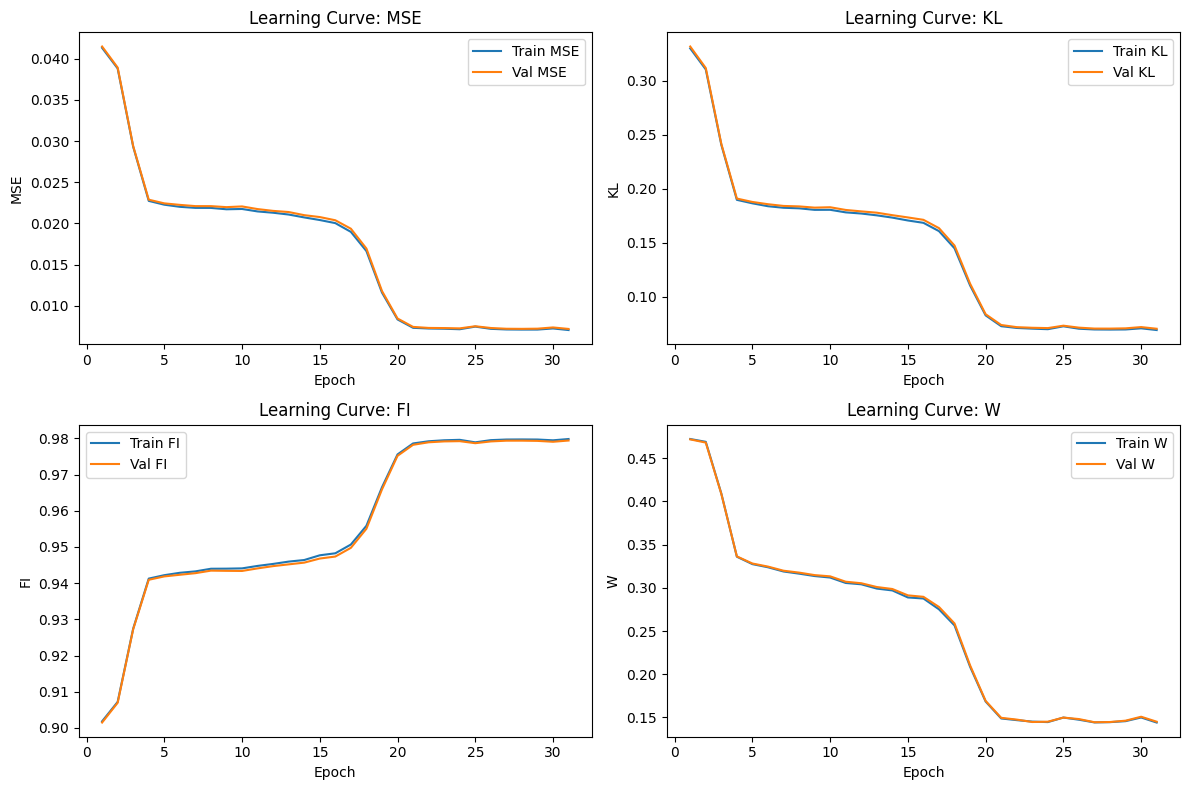

Evaluating CNN on test set...
Group ('classB', 'noisy') 
 MSE: 0.010796 ± 0.011587 | KL: 0.092794 | FI: 0.975125 | W: 0.185448
Group ('classB', 'noiseless') 
 MSE: 0.016029 ± 0.017300 | KL: 0.146983 | FI: 0.956993 | W: 0.221847
Group ('classA', 'noisy') 
 MSE: 0.001300 ± 0.001042 | KL: 0.015905 | FI: 0.995580 | W: 0.091631
Group ('classA', 'noiseless') 
 MSE: 0.001353 ± 0.001209 | KL: 0.027697 | FI: 0.990469 | W: 0.092407
CLASSB | noisy     
 MSE: 0.01080, KL: 0.09279, FI: 0.97512, W: 0.18545
CLASSB | noiseless 
 MSE: 0.01603, KL: 0.14698, FI: 0.95699, W: 0.22185
CLASSA | noisy     
 MSE: 0.00130, KL: 0.01591, FI: 0.99558, W: 0.09163
CLASSA | noiseless 
 MSE: 0.00135, KL: 0.02770, FI: 0.99047, W: 0.09241
Plotting CNN metric distributions on test set...


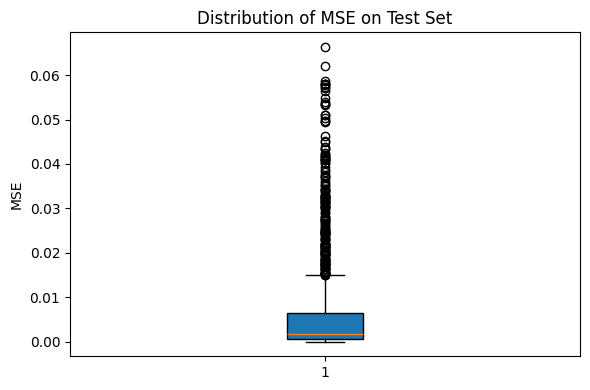

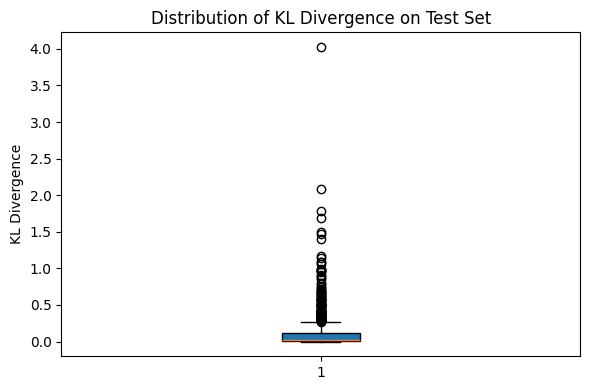

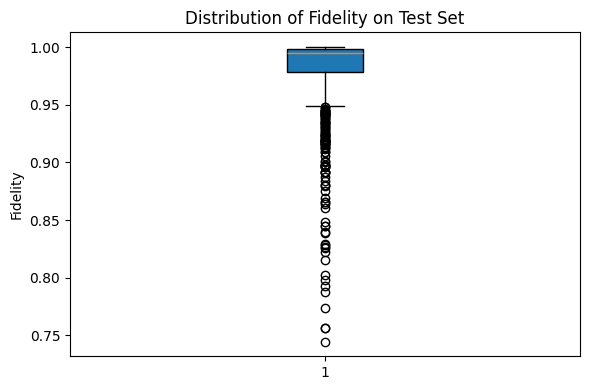

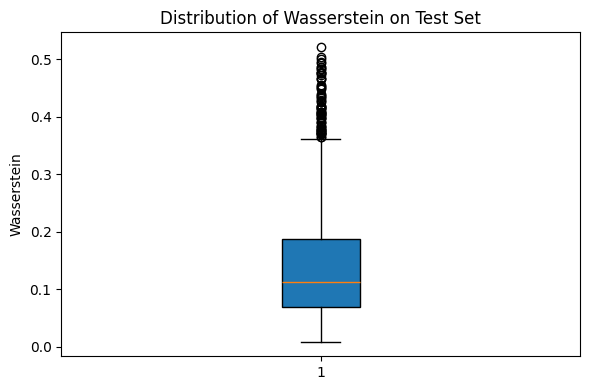

Visualizing CNN predictions (per-group samples)...


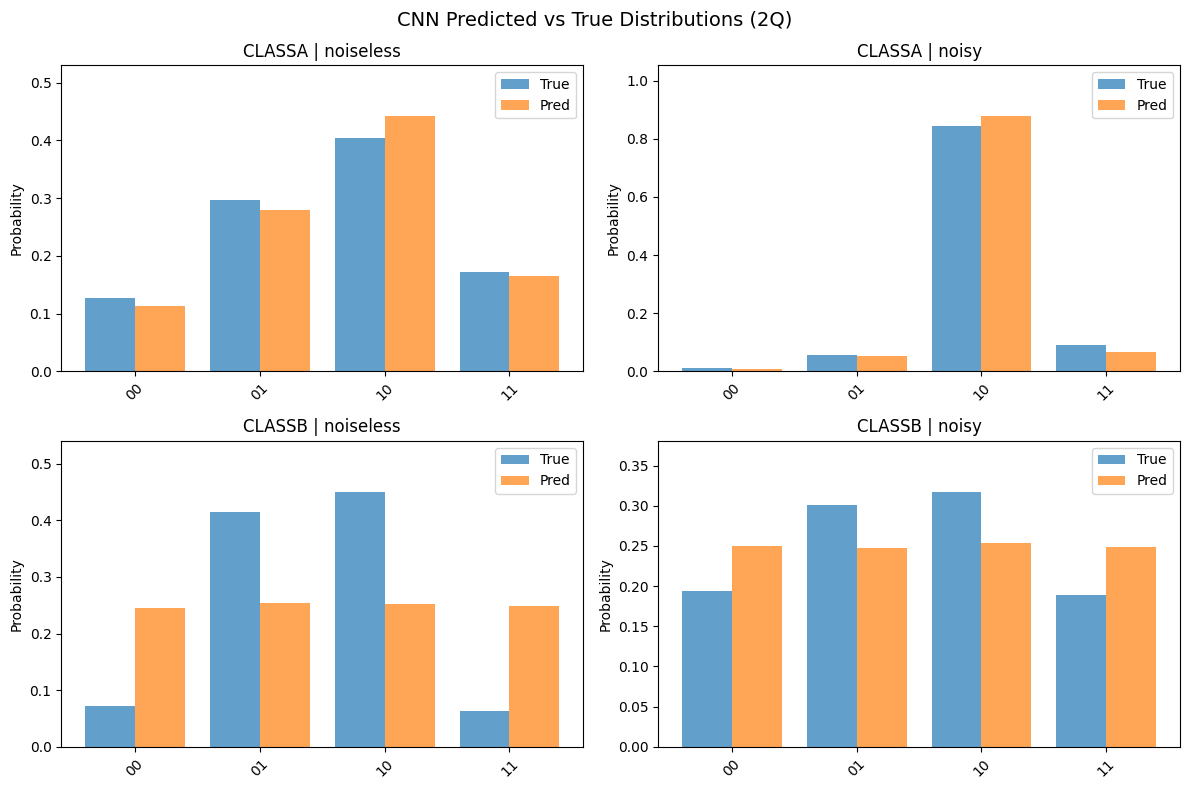

Saved CNN model to ../models/cnn_models\2q_cnn.pt


In [20]:
results_2q = run_qubit_experiment(2)

## 3-qubit experiment


3-Qubit CNN Experiment
Loaded 19200 samples.
Full set outcome entropy: 2.9927 bits
Train: 13437, Val: 3837, Test: 1926
Entropy:
 Train: 2.9926, Val: 2.9925, Test: 2.9931
CNN Model has 1,211,768 parameters.
Skipping complex reshape for: conv.weight (shape torch.Size([135, 27, 5]) → torch.Size([270, 27, 5]))
Loaded and interpolated weights from 2q to 3q CNN.
Frozen layers for 10 epochs.
Starting CNN training...
Epoch 01 | Train MSE: 0.01543±0.01864, KL: 0.38614, FI: 0.89017, W: 0.74487 | Val MSE: 0.01530±0.01834, KL: 0.38458, FI: 0.89055, W: 0.74347
Epoch 02 | Train MSE: 0.01218±0.01601, KL: 0.30402, FI: 0.91159, W: 0.64559 | Val MSE: 0.01194±0.01542, KL: 0.30056, FI: 0.91256, W: 0.64024
Epoch 03 | Train MSE: 0.01169±0.01554, KL: 0.29469, FI: 0.91415, W: 0.61907 | Val MSE: 0.01142±0.01494, KL: 0.29072, FI: 0.91528, W: 0.61271
Epoch 04 | Train MSE: 0.01150±0.01536, KL: 0.28933, FI: 0.91535, W: 0.60822 | Val MSE: 0.01124±0.01479, KL: 0.28564, FI: 0.91643, W: 0.60183
Epoch 05 | Train MSE: 

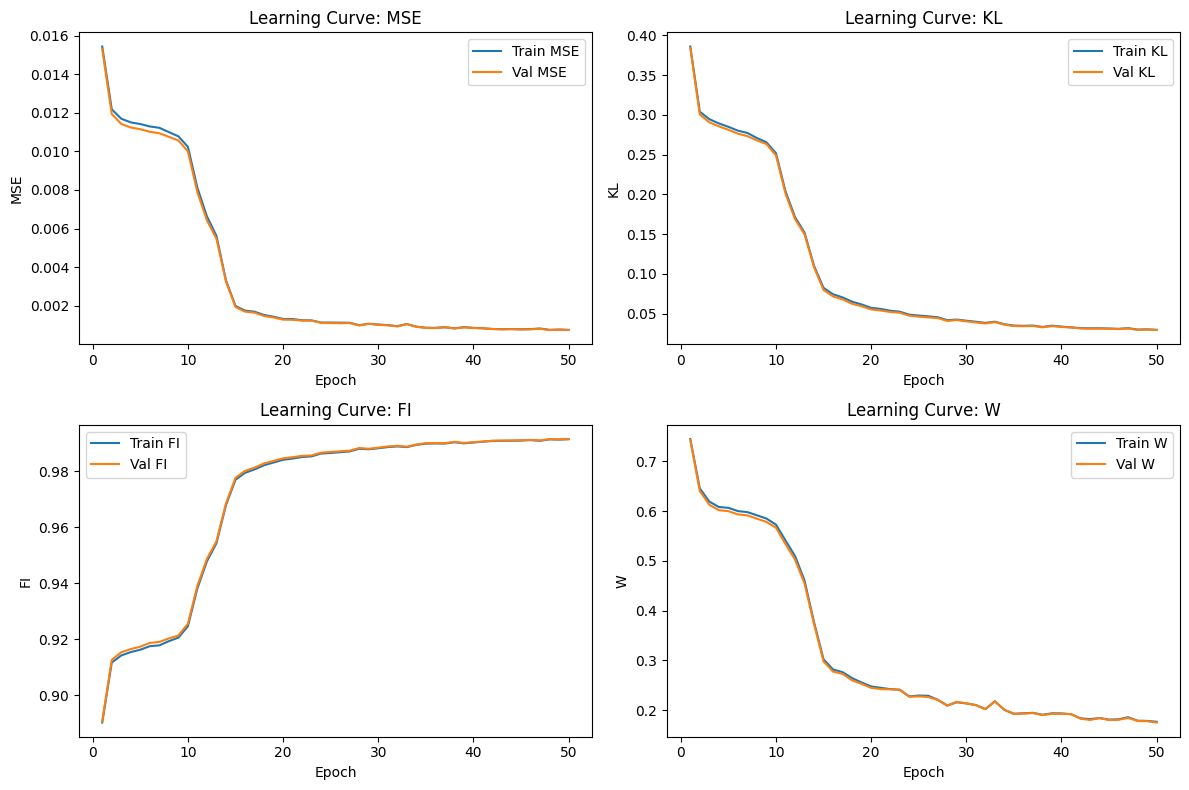

Evaluating CNN on test set...
Group ('classB', 'noiseless') 
 MSE: 0.001298 ± 0.001537 | KL: 0.047045 | FI: 0.986500 | W: 0.217414
Group ('classB', 'noisy') 
 MSE: 0.000689 ± 0.000677 | KL: 0.021692 | FI: 0.994416 | W: 0.175329
Group ('classA', 'noisy') 
 MSE: 0.000428 ± 0.000264 | KL: 0.020745 | FI: 0.994299 | W: 0.158671
Group ('classA', 'noiseless') 
 MSE: 0.000536 ± 0.000370 | KL: 0.029763 | FI: 0.990195 | W: 0.150504
CLASSB | noiseless 
 MSE: 0.00130, KL: 0.04705, FI: 0.98650, W: 0.21741
CLASSB | noisy     
 MSE: 0.00069, KL: 0.02169, FI: 0.99442, W: 0.17533
CLASSA | noisy     
 MSE: 0.00043, KL: 0.02074, FI: 0.99430, W: 0.15867
CLASSA | noiseless 
 MSE: 0.00054, KL: 0.02976, FI: 0.99020, W: 0.15050
Plotting CNN metric distributions on test set...


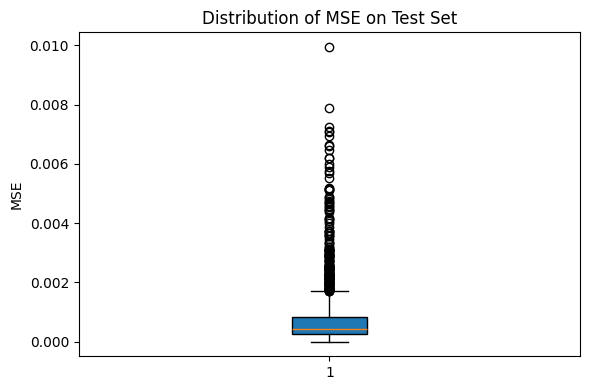

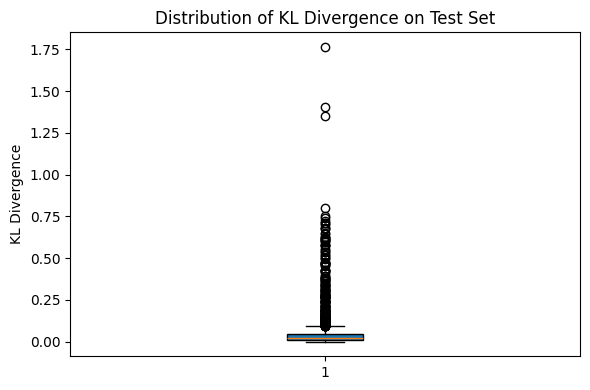

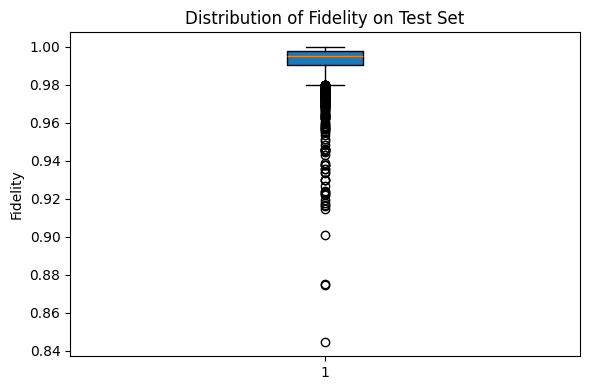

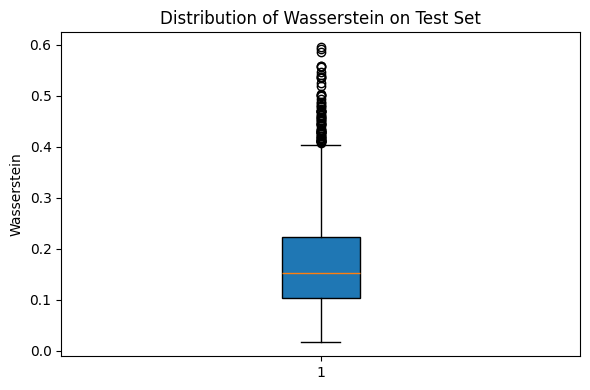

Visualizing CNN predictions (per-group samples)...


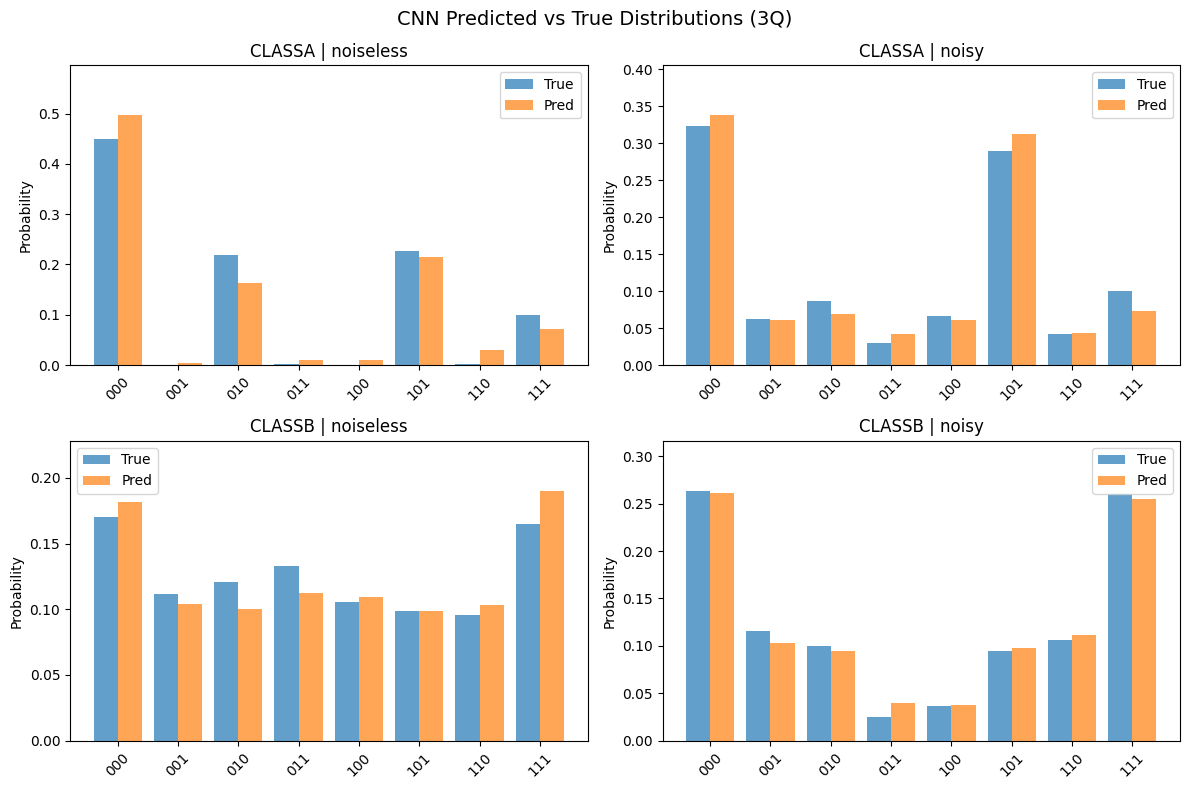

Saved CNN model to ../models/cnn_models\3q_cnn.pt


In [21]:
results_3q = run_qubit_experiment(3, epochs=50)

## 4-qubit experiment


4-Qubit CNN Experiment
Loaded 38400 samples.
Full set outcome entropy: 3.9894 bits
Train: 26872, Val: 7674, Test: 3854
Entropy:
 Train: 3.9895, Val: 3.9896, Test: 3.9884
CNN Model has 2,698,936 parameters.
Skipping complex reshape for: conv.weight (shape torch.Size([270, 27, 5]) → torch.Size([405, 27, 5]))
Loaded and interpolated weights from 3q to 4q CNN.
Frozen layers for 10 epochs.
Starting CNN training...
Epoch 01 | Train MSE: 0.00627±0.00655, KL: 0.56880, FI: 0.83969, W: 1.81529 | Val MSE: 0.00618±0.00649, KL: 0.56271, FI: 0.84177, W: 1.78982
Epoch 02 | Train MSE: 0.00627±0.00655, KL: 0.56821, FI: 0.83984, W: 1.81715 | Val MSE: 0.00618±0.00648, KL: 0.56187, FI: 0.84197, W: 1.79118
Epoch 03 | Train MSE: 0.00627±0.00655, KL: 0.56798, FI: 0.83992, W: 1.81631 | Val MSE: 0.00618±0.00649, KL: 0.56206, FI: 0.84197, W: 1.79101
Epoch 04 | Train MSE: 0.00626±0.00654, KL: 0.56741, FI: 0.83992, W: 1.81201 | Val MSE: 0.00617±0.00648, KL: 0.56117, FI: 0.84203, W: 1.78608
Epoch 05 | Train MSE: 

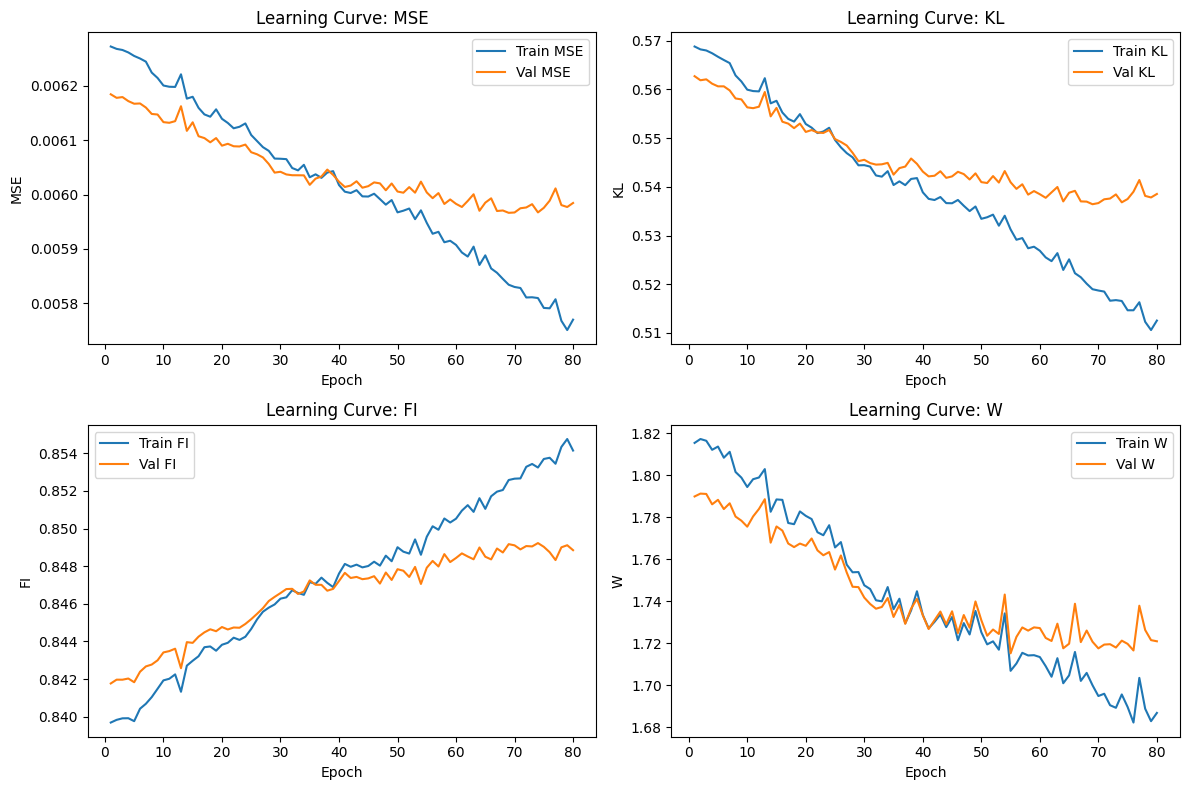

Evaluating CNN on test set...
Group ('classA', 'noisy') 
 MSE: 0.007635 ± 0.004598 | KL: 0.682274 | FI: 0.819718 | W: 2.410668
Group ('classB', 'noisy') 
 MSE: 0.001528 ± 0.001364 | KL: 0.180131 | FI: 0.949751 | W: 0.825314
Group ('classB', 'noiseless') 
 MSE: 0.002829 ± 0.002722 | KL: 0.319104 | FI: 0.901388 | W: 1.016900
Group ('classA', 'noiseless') 
 MSE: 0.012312 ± 0.008121 | KL: 1.011867 | FI: 0.713124 | W: 2.694500
CLASSA | noisy     
 MSE: 0.00763, KL: 0.68227, FI: 0.81972, W: 2.41067
CLASSB | noisy     
 MSE: 0.00153, KL: 0.18013, FI: 0.94975, W: 0.82531
CLASSB | noiseless 
 MSE: 0.00283, KL: 0.31910, FI: 0.90139, W: 1.01690
CLASSA | noiseless 
 MSE: 0.01231, KL: 1.01187, FI: 0.71312, W: 2.69450
Plotting CNN metric distributions on test set...


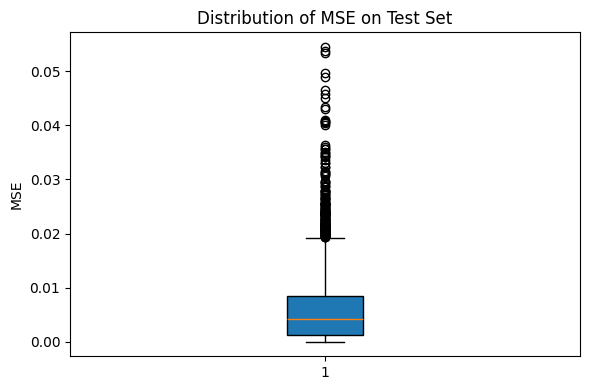

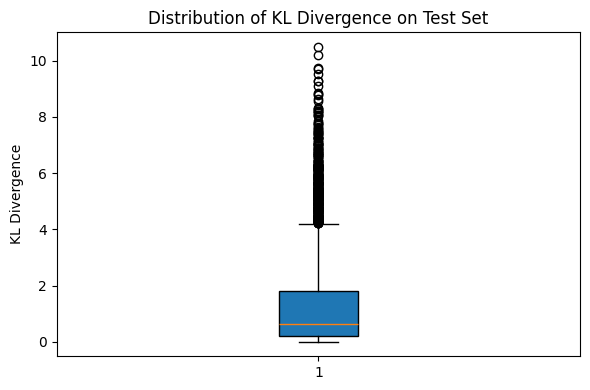

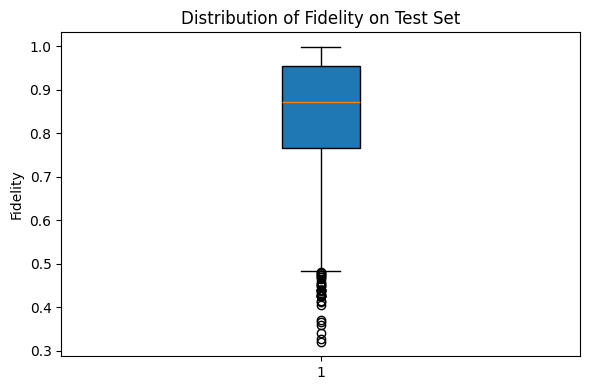

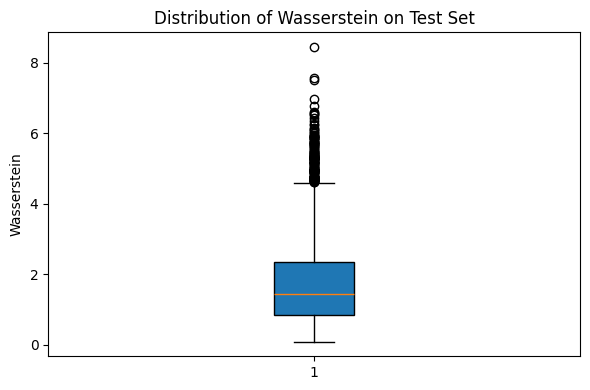

Visualizing CNN predictions (per-group samples)...


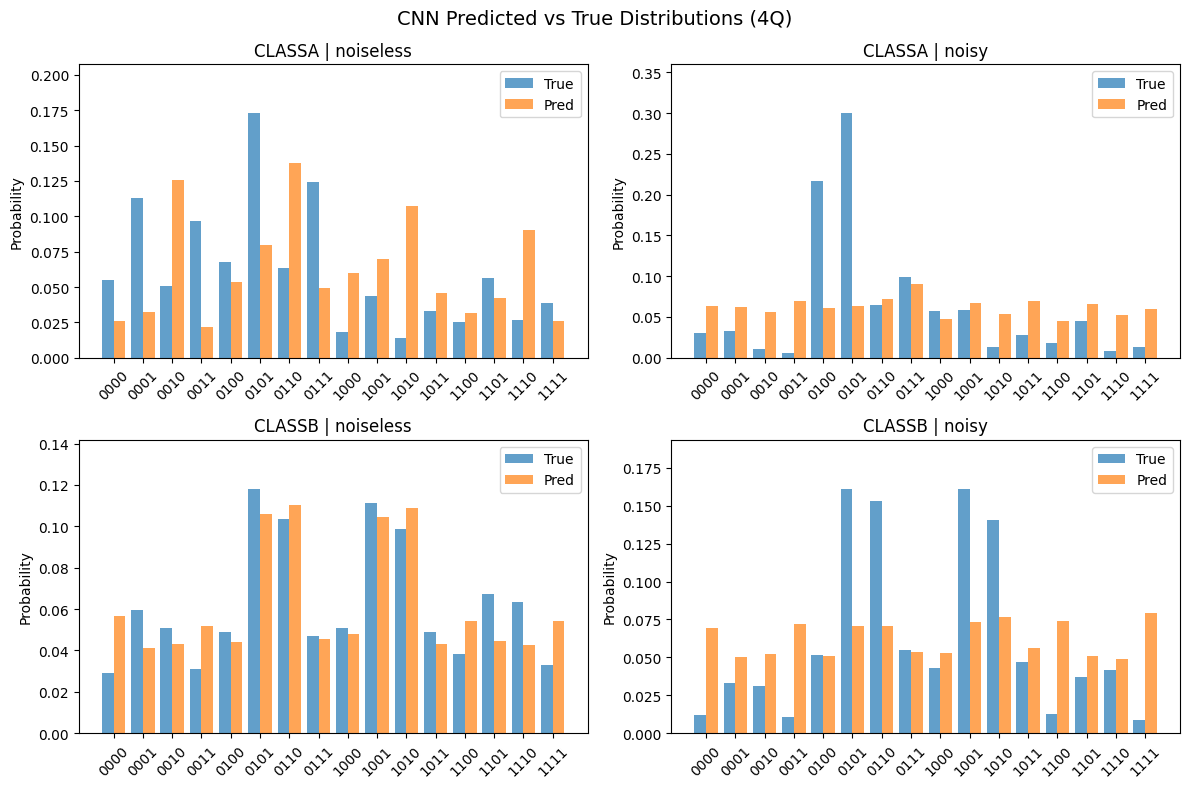

Saved CNN model to ../models/cnn_models\4q_cnn.pt


In [22]:
results_4q = run_qubit_experiment(4, epochs=80)

## 5-qubit experiment


5-Qubit CNN Experiment
Loaded 76800 samples.
Full set outcome entropy: 4.9838 bits
Train: 53745, Val: 15349, Test: 7706
Entropy:
 Train: 4.9836, Val: 4.9841, Test: 4.9843
CNN Model has 4,782,272 parameters.
Skipping complex reshape for: conv.weight (shape torch.Size([405, 27, 5]) → torch.Size([540, 27, 5]))
Loaded and interpolated weights from 4q to 5q CNN.
Frozen layers for 10 epochs.
Starting CNN training...
Epoch 01 | Train MSE: 0.00219±0.00238, KL: 0.67801, FI: 0.81341, W: 2.90935 | Val MSE: 0.00219±0.00239, KL: 0.67858, FI: 0.81343, W: 2.93592
Epoch 02 | Train MSE: 0.00218±0.00238, KL: 0.67587, FI: 0.81390, W: 2.89992 | Val MSE: 0.00219±0.00239, KL: 0.67652, FI: 0.81391, W: 2.92660
Epoch 03 | Train MSE: 0.00218±0.00238, KL: 0.67499, FI: 0.81431, W: 2.89543 | Val MSE: 0.00219±0.00239, KL: 0.67563, FI: 0.81431, W: 2.92241
Epoch 04 | Train MSE: 0.00218±0.00238, KL: 0.67313, FI: 0.81466, W: 2.89898 | Val MSE: 0.00219±0.00239, KL: 0.67414, FI: 0.81458, W: 2.92662
Epoch 05 | Train MSE:

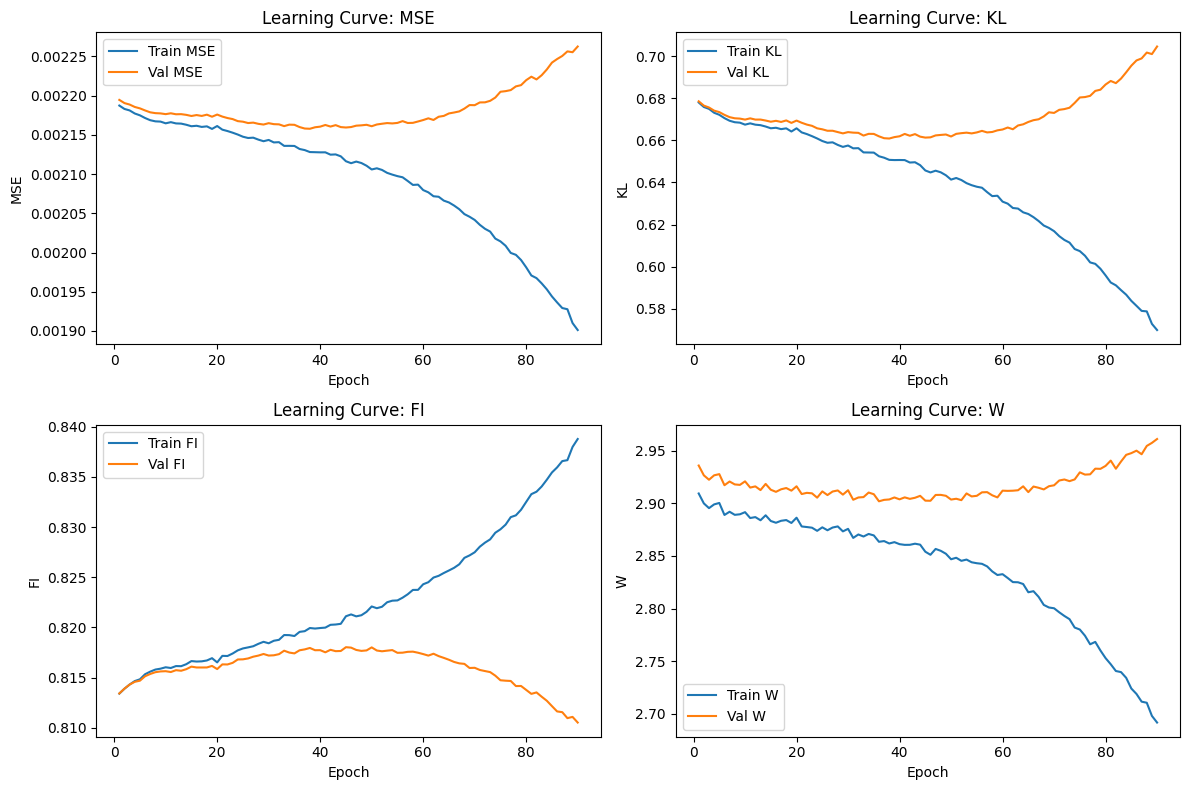

Evaluating CNN on test set...
Group ('classB', 'noisy') 
 MSE: 0.000478 ± 0.000376 | KL: 0.210618 | FI: 0.943603 | W: 1.176179
Group ('classB', 'noiseless') 
 MSE: 0.000864 ± 0.000712 | KL: 0.372362 | FI: 0.891739 | W: 1.492424
Group ('classA', 'noiseless') 
 MSE: 0.004699 ± 0.002797 | KL: 1.322125 | FI: 0.642355 | W: 4.788640
Group ('classA', 'noisy') 
 MSE: 0.002917 ± 0.001661 | KL: 0.903558 | FI: 0.766385 | W: 4.384833
CLASSB | noisy     
 MSE: 0.00048, KL: 0.21062, FI: 0.94360, W: 1.17618
CLASSB | noiseless 
 MSE: 0.00086, KL: 0.37236, FI: 0.89174, W: 1.49242
CLASSA | noiseless 
 MSE: 0.00470, KL: 1.32213, FI: 0.64236, W: 4.78864
CLASSA | noisy     
 MSE: 0.00292, KL: 0.90356, FI: 0.76638, W: 4.38483
Plotting CNN metric distributions on test set...


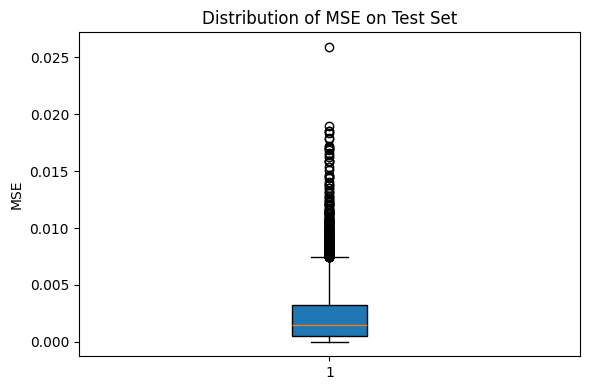

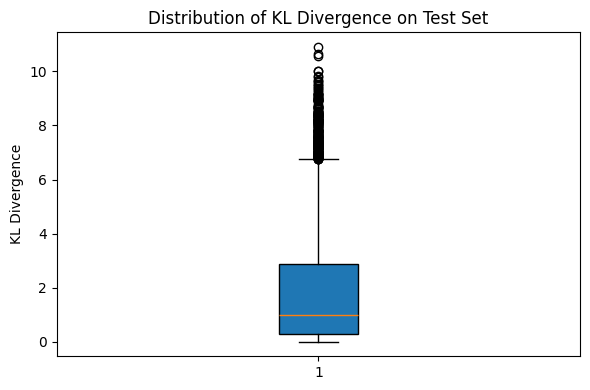

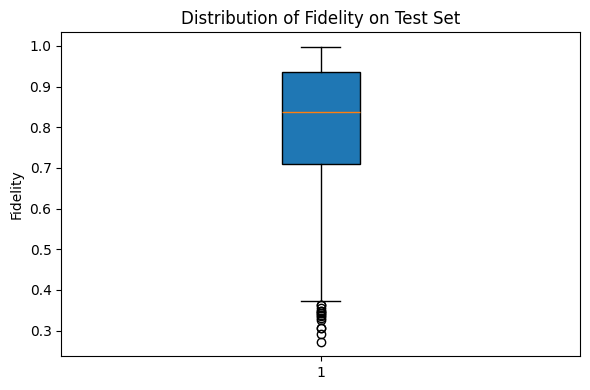

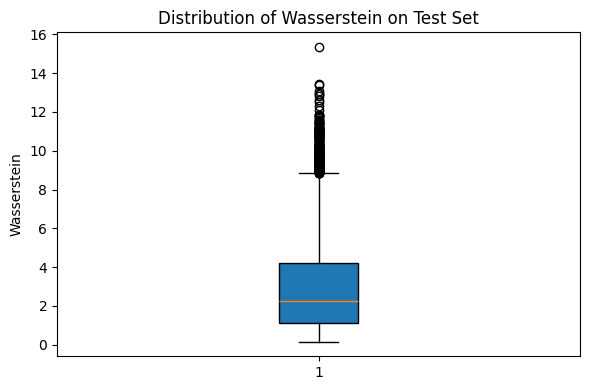

Visualizing CNN predictions (per-group samples)...


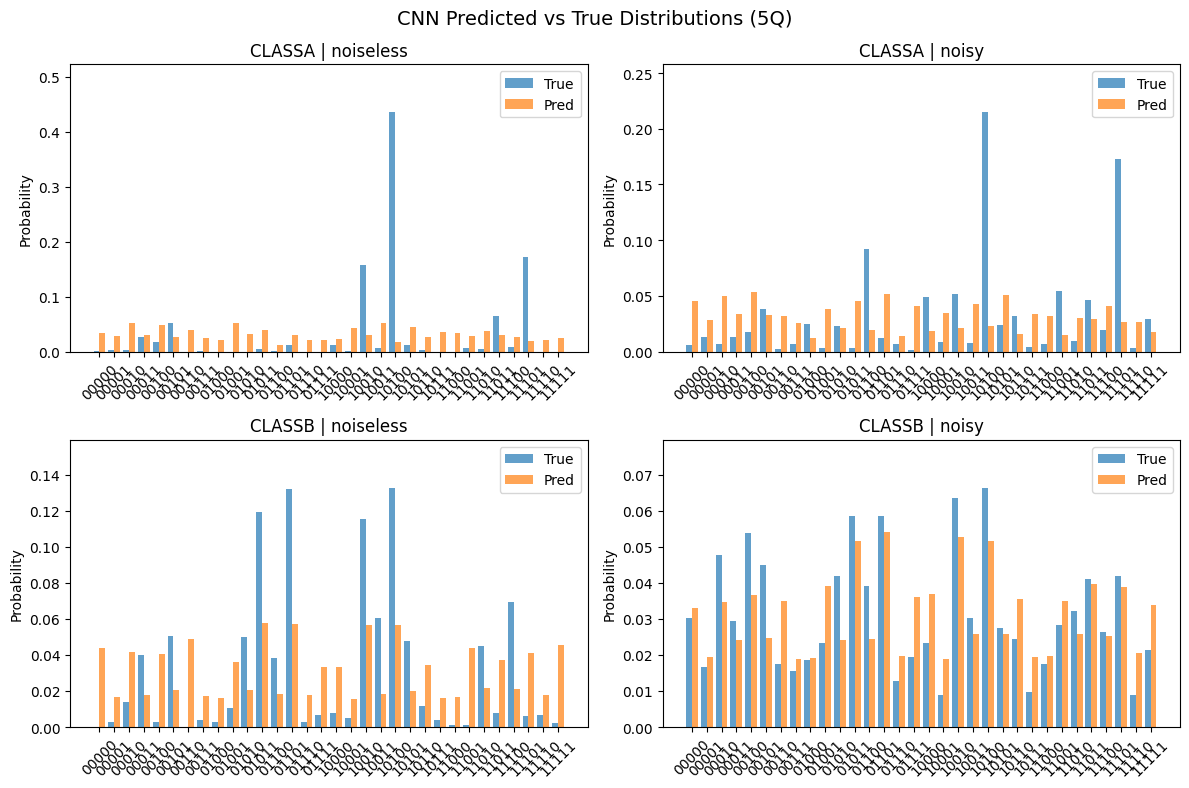

Saved CNN model to ../models/cnn_models\5q_cnn.pt


In [23]:
results_5q = run_qubit_experiment(5, epochs=90)